The purpose of this code is to find the diffusion coefficient $D$ of the rhodamine 6G as a mock for the drug neratinib in breast tumor spheroids. The concentration field is given for different times in the form of images taken via a confocal microscope and it is required to find the diffusivity. This is an inverse problem and we adopt the Bayesian approach to find the diffusivity. 

It is important to note that as light penetrates in media, its intensity decreases exponentially with depth, according to Beer-Lambert law.  Therefore, the attenuation coefficient $a$ is another unknown, which should be determined alongside the diffusion coefficient. It's assumed that light intensity after correction is proportional to the concentration. Consequently, the intensity obtained from the images or the concentration $C_m$ in a sphere with radius $R$ and Dirichlet boundary condition $C_m=C_0$ at the boundary $r=R$ is related to the diffusivity and attenuation coefficients as follows:

$$\frac{C_m}{C_0}=\exp(-az)\left[1+\frac{2R}{r \pi}\sum\limits_{n=1}^\infty \frac{(-1)^n}{n}\sin\left(\frac{n\pi r}{R}\right)\exp\left(-(\frac{n\pi}{R})^2Dt\right)\right].$$

To make the inverse problem tractable, we reduce the degrees of freedom, meaning that instead of using the entire concentration field, we use the average concentration field defined over the circular region in the images taken at a slice passing through the center of a spheroid as follows:

$$\hat{C}=\frac{1}{\pi R^2} \int_0^R 2\pi r \frac{C_m}{C_0} dr$$

In other words, our goal is to find the values of $D$ and $a$ from the values of $\hat{C}(t)$ given at different time steps. To this end, we first non-dimensionalize the parameters with respect to reference values $D_0$ and $a_0$as follows:
$$x_1=\log (\frac{D}{D_0})=\hat{D},\quad x_2=\log (\frac{a}{a_0})=\hat{a}.$$

Bayes' theorem states that the observed data vector, $\mathbf{y}$, can be related to the parameter of interest, $\mathbf{x}$, through:

$$p(\mathbf{x}|\mathbf{y})=\frac{p(\mathbf{y}|\mathbf{x})p(\mathbf{x})}{\int p(\mathbf{y}|\mathbf{x})p(\mathbf{x})d\mathbf{x}}, \quad \int p(\mathbf{y}|\mathbf{x})p(\mathbf{x})d\mathbf{x}=Z.$$

In the above equation, $p(\mathbf{x}|\mathbf{y})$ denotes the posterior knowledge about the parameter of interest, $\mathbf{x}$. The term $p(\mathbf{y}|\mathbf{x})$ denotes the likelihood and $p(\mathbf{x})$ is the prior probabilistic knowledge about $\mathbf{x}$. The integral term, $Z$, is the normalizing constant, which is referred to as  partition function.
The likelihood accounts for the deviations of the model from the actual results. Indeed, it is the measure of the difference between the observed data and the model prediction. Several sources may lead to errors in our predictive modeling. The major source for the error is the pixel noise that can be attributed to environmental factors and photon noises.

The summation of all errors can be nested in a single noise term, $\epsilon$, which relates the model prediction $f(\mathbf{x})$ to the observed data as in the following: 
\begin{equation}
y={f}(\mathbf{x})+\epsilon.
\end{equation}
A proper way to model the noise is to assign a normal or Gaussian distribution, which can effectively model the random noises.
\begin{equation}
\epsilon=\mathcal{N}\left(0|\sigma^2 \right).
\end{equation}
In the above equation, $\sigma$ denotes the standard deviation. This Gaussian noise can be manifested in the likelihood of the data vector with $N$ independent observations $p(\mathbf{y}|\mathbf{x})$ through a normal distribution as the following:
\begin{equation}
p(\mathbf{y}|\mathbf{x})=\prod_{i=1}^{N}  p(y_i|\mathbf{x})=\prod_{i=1}^{N} \mathcal{N}\left({f_i}(\mathbf{x})| \sigma_i \right). 
\end{equation}
Assuming a constant deviation, $\sigma$, for all the independent observations, the likelihood can be simplified as follows.
\begin{equation}
   p(\mathbf{y}|\mathbf{x}) \propto \exp\left(\frac{\sum \limits_{i=1}^N(y_i-f_i(\mathbf{x})^2)}{2\sigma ^2}\right).  
\end{equation}
Based on how accurate the model prediction is, the values of noise variance can vary widely. In this work, since the model prediction $f(\mathbf{x})$ and experimental data is in the range $[0,1]$ and the data are noisy, we assumed the variance of the difference between the model prediction and the experimental data to be $0.1$ corresponding to $\sigma^2 =0.01$.  Finding the posterior $p(\mathbf{x}|\mathbf{y})$ is the most challenging part in Bayesian inference since the $Z$ term is not generally analytically available, except for some few cases. A common method to circumvent the difficulties associated with the direct calculation of the partition function is to use MCMC to sample from the posterior. In the current work, we use the No-U-Turn Sampler (NUTS) of PyMC3 to sample from the posterior. 

In [2]:
#########Mounting your google drive################
##################################################
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In this section, we define functions for calculating the average non-dimensional diffusion and attenuation coefficients in the form of the theano tensors

In [3]:
!pip install numpngw
!pip install tifffile
!pip install --upgrade pymc3 
!pip install arviz
######Required Modules#########
###############################
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
## for reading and handling images
from PIL import Image
from skimage import io
import numpngw #for handling images in png format and saving my output images as png
##
##for finding the locations of images and reading them
import glob
import os
##
from scipy import ndimage##denoising
from sklearn.linear_model import LinearRegression ##regression
import scipy.stats as st
import theano
import scipy
import theano as th
from theano import shared, function, tensor as tt
import pymc3 as pm
import math
import scipy.stats as st
import scipy
import arviz as az
import pandas as pd
import io
import requests
from theano.tensor import _shared
import matplotlib as mpl
import matplotlib.pyplot as plt

In [4]:
def exponen_matrix_of_radius(a,im,R_ave):
    x_center=int(im.shape[0]*0.5)+1
    y_center=int(im.shape[1]*0.5)+1
    r_matrix=np.ones((im.shape[0],im.shape[1]))*R_ave
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            if np.sqrt((i-y_center)**2+(j-x_center)**2)<R_ave: #### to avoid having nonzer points at the center
               r_matrix[i,j]=np.copy(np.sqrt((i-y_center)**2+(j-x_center)**2))
    return  np.exp(a*np.sqrt(np.power(R_ave*np.ones((im.shape[0],im.shape[1])),2)-np.power(r_matrix,2)))

def c_nut(im):
    cmaxs=im[im>0.9*np.max(im)]
    return np.average(cmaxs)
################################Average Modeling###############################
###############################################################################
def concentration_average_normalized(xD,delta_t,N):
    c=1
    D0=D_guess
    D=D0*tt.exp(xD)
    for n in range(1,N):
        c=c-4/np.pi**2*(tt.exp(-(n*np.pi/R_ave)**2*D*delta_t))/n**2*(1-(-1)**n)
    return c
################################new average modeling####################################################
def concentration_average_attenuation(xD,delta_t,N,xa):
    a=a0*tt.exp(xa)
    c=2*(0.005*tt.exp(0.99*a*R_ave)+0.015*tt.exp(0.97*a*R_ave)+0.025*tt.exp(0.95*a*R_ave)+0.035*tt.exp(0.92*a*R_ave)+
         0.045*tt.exp(0.87*a*R_ave)+0.055*tt.exp(0.8*a*R_ave)+0.065*tt.exp(0.71*a*R_ave)+0.075*tt.exp(0.6*a*R_ave)+
         0.085*tt.exp(0.43*a*R_ave)+0.095)
    D0=D_guess
    D=D0*tt.exp(xD)
    for n in range(1,N):
        c=c-4*(-1)**n/n/np.pi*(tt.exp(-(n*np.pi/R_ave)**2*D*delta_t))*((tt.cos(0.1*np.pi*n)-1)*tt.exp(0.99*a*R_ave)/n/np.pi+
                                                                (tt.cos(0.2*np.pi*n)-tt.cos(0.1*np.pi*n))*tt.exp(0.97*a*R_ave)/n/np.pi+(tt.cos(0.3*np.pi*n)-tt.cos(0.2*np.pi*n))*tt.exp(0.95*a*R_ave)/n/np.pi+(tt.cos(0.4*np.pi*n)-tt.cos(0.3*np.pi*n))*tt.exp(0.92*a*R_ave)/n/np.pi+
                                                                (tt.cos(0.5*np.pi*n)-tt.cos(0.4*np.pi*n))*tt.exp(0.87*a*R_ave)/n/np.pi+(tt.cos(0.6*np.pi*n)-tt.cos(0.5*np.pi*n))*tt.exp(0.8*a*R_ave)/n/np.pi+(tt.cos(0.7*np.pi*n)-tt.cos(0.6*np.pi*n))*tt.exp(0.71*a*R_ave)/n/np.pi+
                                                                (tt.cos(0.8*np.pi*n)-tt.cos(0.7*np.pi*n))*tt.exp(0.6*a*R_ave)/n/np.pi+(tt.cos(0.9*np.pi*n)-tt.cos(0.8*np.pi*n))*tt.exp(0.43*a*R_ave)/n/np.pi+(tt.cos(n*np.pi)-tt.cos(0.9*n*np.pi))/n/np.pi)
    return c

def concentration_average_attenuation_new(xD,delta_t,N,nof,xa):
    a=a0*tt.exp(xa)
    s1=0
    dx=1/nof
    xx=np.linspace(0, 1, num=nof)
    for x in xx:
        s1=s1+x*tt.exp(a*R_ave*tt.sqrt(1-x**2))*dx   
    c=2*s1
    D0=D_guess
    D=D0*tt.exp(xD)
    for n in range(1,N):
        s2=0
        for  x in xx:
             s2=s2+tt.exp(a*R_ave*tt.sqrt(1-x**2))*tt.sin(n*np.pi*x)*dx
        c=c+4*(-1)**n/n*tt.exp(-(n*np.pi/R_ave)**2*D*delta_t)*s2/np.pi
    return c,s1,s2



In [5]:
###########Read the images#############
########################################
input_dir_2="/content/gdrive/MyDrive/diffusion project/HMF/BMshHMF/spheroid9/"
output_dir="/content/gdrive/MyDrive/diffusion project/HMF/BMshHMF/spheroid9results/"
import tifffile as tiff
from PIL import Image
##open all the files
data_path = os.path.join(input_dir_2,'*tif')
files = glob.glob(data_path)
files.sort()#sort images by their name
spheroid='sph9'
param='BMsHMF'
##
## Read all images
img_all=[]#initialization
for f1 in files:
    imgg = np.array(Image.open(f1))
    #imgg = np.array(tiff.imread(f1))
    img_all.append(imgg)
print(len(img_all))
img_all[1].shape

36


(1024, 1031, 3)

In order to find the average concentration in the circles which lie at the interface of the plane of imaging and the spheroids, we define a rectangular region around the circles, where the rectangle encloses the circle. Then we find the average concentration in the rectangle. Then, we subtract this value from the average noise values.

In [6]:
#####################provide these values################
R_ave=156#average radius
####coordinates of the rectngle around the circles#####
x_start=364
y_start=347
x_end=685
y_end=650
################################################################
imgs=[]
for num in range(len(img_all)):
    #imgs.append(np.array(img_all[num][y_center-R_max:y_center+R_max+1,x_center-R_max:x_center+R_max,0],dtype=np.int))
    imgs.append(np.array(img_all[num][y_start:y_end,x_start:x_end,0],dtype=np.uint16))
    #imgs.append(np.array(img_all[num][y_start:y_end,x_start:x_end],dtype=np.int))
#fig,ax = plt.subplots()    
#myax = ax.imshow(imgs[22])
a=0.03
c0=255
c0=c_nut(imgs[len(img_all)-1])
y=[]
l_inv=20
im_cut=np.copy(imgs)
I2_bebin=[]
jam=[]
for num in range(len(img_all)):
    A=np.array(im_cut[1]).shape[0]*np.array(im_cut[1]).shape[1]
    A1=np.pi*R_ave**2
    A2=A-A1
    #c0=c_nut(img_all[num])
    I2=np.average(im_cut[num][im_cut[num].shape[0]-l_inv:,im_cut[num].shape[1]-l_inv:])
    I2_bebin.append(I2)
    jam.append(np.sum(im_cut[num]))
    y.append((np.sum(im_cut[num])-A2*I2)/A1/c0)
data=np.array(y[0:23])
print(c0)
print(data)
print(jam)
print(I2_bebin)
np.savetxt(output_dir+spheroid+param+'.csv', data , delimiter=',')

247.25497765136123
[0.08780375 0.10982619 0.12546785 0.14625609 0.16913874 0.18702156
 0.1858111  0.20523284 0.22687856 0.24246323 0.23283452 0.26745995
 0.27887722 0.28913901 0.27027333 0.30130184 0.32713166 0.33006616
 0.33545882 0.34088129 0.34529908 0.36646431 0.4008788 ]
[1995874, 2461911, 2799473, 3210029, 3676564, 4029440, 4022685, 4386548, 4807955, 5113642, 4927099, 5593661, 5808916, 6040045, 5685341, 6297122, 6818901, 6906888, 7041395, 7177818, 7254411, 7691394, 8377743, 7878510, 7966373, 8405341, 8489589, 8830934, 9040007, 9519397, 9473538, 9303953, 9177589, 10269160, 9624036, 9764501]
[16.15, 18.54, 20.5525, 21.3975, 23.03, 23.7425, 24.5175, 24.36, 24.9475, 25.48, 25.2625, 25.84, 25.8125, 27.5975, 27.69, 28.9025, 30.5125, 32.075, 33.64, 35.27, 34.9375, 36.71, 38.43, 40.575, 41.73, 43.2575, 45.19, 45.9125, 45.685, 45.845, 46.78, 46.015, 44.4675, 45.175, 45.8775, 44.0875]


Here, we display a rectangle enclosing the spheroid

[[17 17 21 19 14 22 17 18 23 13 21 16 15 20 21 20 24 22 17 21]
 [20 27 19 20 19 17 16 15 20 20 19 22 22 20 19 17 18 19 15 18]
 [18 14 19 12 21 22 16 21 21 16 20 17 26 14 17 25 18 17 16 19]
 [20 14 17 18 22 13 19 16 17 17 18 19 19 22 21 19 25 18 18 20]
 [18 22 25 14 21 19 20 25 16 24 21 17 21 20 19 17 20 22 20 14]
 [19 19 25 18 21 24 18 21 19 16 14 22 23 17 19 16 13 19 20 21]
 [20 17 19 21 19 19 16 17 20 24 20 19 21 20 24 23 17 17 21 16]
 [15 16 16 15 18 21 16 16 13 22 19 25 20 17 18 16 18 18 19 22]
 [15 18 25 20 14 14 21 19 23 20 19 18 16 18 18 20 20 19 22 24]
 [16 19 18 15 16 17 24 14 17 20 18 14 16 17 21 20 16 14 17 16]
 [16 14 14 18 20 21 22 15 17 21 21 18 22 20 21 22 22 12 21 18]
 [25 17 24 20 15 27 20 16 17 16 19 15 21 19 22 18 25 19 16 20]
 [21 15 19 15 19 20 19 21 18 19 16 13 20 18 21 17 16 13 21 15]
 [19 17 20 16 19 19 18 18 13 19 16 16 25 16 20 17 15 16 22 20]
 [19 19 18 19 21 23 20 18 18 10 24 20 16 18 17 18 22 21 19 15]
 [14 20 19 21 23 17 13 16 17 19 14 23 17 19 18 17 19 19

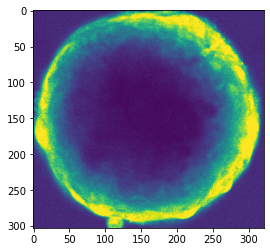

In [7]:
fig,ax = plt.subplots()    
#myax = ax.imshow(img_all[2][290:722,300:720,0])
myax = ax.imshow(img_all[22][y_start:y_end,x_start:x_end,0])
#myax = ax.imshow(img_exp[20])

#np.max(img_exp[2])
#print(exponen_matrix_of_radius(a,imgs[num],R_ave,x_center,y_center))
num=1
print(im_cut[num][im_cut[num].shape[0]-l_inv:,im_cut[num].shape[1]-l_inv:])

In [8]:
N=20
delta_t=_shared(np.array(range(1,len(data)+1))*60*10)
ts=np.array(range(1,len(data)+1))*60*10
D_guess=0.52
D0=D_guess
a0=-0.024
nof=80


Here, we define the prior and the likelihood to calculate the posterior using PyMC3. The Gaussian prior is used for both the attenuation and diffusion coefficients.

In [9]:
diffusion_model1 = pm.Model()
gamma1_2=0.1
gamma2_2=0.1
sigma2=0.01
prior='Gaussian'
#prior='Uniform'
N=20
with diffusion_model1:
    # define the prior 
    xD = pm.Normal('xD', mu=0, sigma=np.sqrt(gamma1_2))
    xa = pm.Normal('xa', mu=0, sigma=np.sqrt(gamma2_2))
    #xD=pm.Uniform('xD',lower=-2.5, upper=2.5)
    #xa=pm.Uniform('xa',lower=-2.5, upper=2.5)
    f_x=pm.Deterministic('f_x', concentration_average_attenuation_new(xD,delta_t,N,nof,xa)[0])
    # define the likelihood
    y=pm.Normal('y', mu=f_x, sigma=np.sqrt(sigma2), observed=data) 

Here, we burn and thin the sample for further accuracy

In [ ]:
###sampling######

with diffusion_model1:
    trace1 = pm.sample(draws=8000, progressbar=True)
thinned_trace1 = trace1[3000::1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  after removing the cwd from sys.path.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [xa, xD]


Sampling 2 chains for 1_000 tune and 8_000 draw iterations (2_000 + 16_000 draws total) took 997 seconds.


Here, we use the maximum aposteriori criteria to find the diffusion and attenuation coefficients

In [ ]:
map_estimate = pm.find_MAP(model=diffusion_model1)
map_estimate 
D_max_post=np.exp(map_estimate['xD'])*D_guess*0.83**2
a_max_post=np.exp(map_estimate['xa'])*a0/0.83
print('D_max=',D_max_post,'a_max=',a_max_post)
ddaa=np.array([D_max_post, a_max_post])
np.savetxt(output_dir+spheroid+prior+param+'maxpost.csv', np.array(ddaa,dtype='f') , delimiter=',')

Here, we sample from the posterior and use the mean of the posterior for prediction of the diffusivity and attenuation coefficient

In [20]:
ppsamples_D1 = pm.sample_posterior_predictive(samples=10000,model=diffusion_model1, 
                                           trace=thinned_trace1 , 
                                           var_names=['xD'])['xD'] 
ppsamples_a1 = pm.sample_posterior_predictive(samples=10000,model=diffusion_model1, 
                                           trace=thinned_trace1 , 
                                           var_names=['xa'])['xa']  
m_of_D1=np.exp(ppsamples_D1.mean(0))*D0
#print(m_of_D1) 
#print("D=",m_of_D1*0.83**2)    
D_lower_1, D_upper_1 = np.exp(np.percentile(ppsamples_D1, axis=0, q=[2.5, 97.5]))*D0
#print(D_lower_1) 
#print(D_upper_1)

m_of_a1=np.exp(ppsamples_a1.mean(0))*a0
#print(m_of_a1) 
#print('a=',m_of_a1/0.83)    
a_lower_1, a_upper_1 = np.exp(np.percentile(ppsamples_a1, axis=0, q=[2.5, 97.5]))*a0
#print(a_lower_1) 
#print(a_upper_1)  

m_of_D1=np.exp(ppsamples_D1.mean(0))*D0
np.savetxt(output_dir+spheroid+prior+param+'_posterior_D.csv', ppsamples_D1 , delimiter=',')
np.savetxt(output_dir+spheroid+prior+param+'_posterior_a.csv', ppsamples_a1 , delimiter=',')
m_of_D2=m_of_D1
#print(m_of_D1) 
#print(m_of_D1)    
D_lower_1, D_upper_1 = np.exp(np.percentile(ppsamples_D1, axis=0, q=[2.5, 97.5]))*D0
#print(D_lower_1) 
#print(D_upper_1)      

print('Mean_D_poster=',np.mean(ppsamples_D1)) #mean of posterior prediction for D
print('Sd_D_poster = ',np.std(ppsamples_D1)) #standard deviattion of posterior prediction for D
print('Mean_a_poster=',np.mean(ppsamples_a1))#mean of posterior prediction for D
print('Sd_a_poster = ',np.std(ppsamples_a1)) #standard deviattion of posterior prediction for D
sigd=[np.mean(ppsamples_D1), np.std(ppsamples_D1)]
np.savetxt(output_dir+spheroid+prior+'new_'+param+'_sigD.csv', np.array(sigd,dtype='f') , delimiter=',')
siga=[np.mean(ppsamples_a1), np.std(ppsamples_a1)]
np.savetxt(output_dir+spheroid+prior+'new_'+param+'_siga.csv', np.array(siga,dtype='f') , delimiter=',')

Mean_D_poster= -0.08978619273835532
Sd_D_poster =  0.28445655790747
Mean_a_poster= -0.62422895495219
Sd_a_poster =  0.10329386299721918


Here, we present the posterion distribution for the diffusion coefficient

0.11311993072146989
0.9831499500357546


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


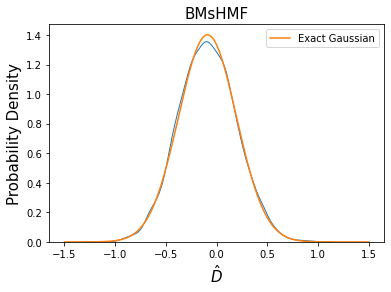

In [31]:
D_poster=pm.sample_posterior_predictive(samples=10000,model=diffusion_model1, 
                                           trace=thinned_trace1 , 
                                           var_names=['xD'])['xD'] 

import seaborn as sns
D_post=D0*0.83**2*np.exp(D_poster) 
print(np.min(D_post)) 
print(np.max(D_post))                                                                                 
sns.distplot(D_poster, hist = False, kde = True, kde_kws = {'linewidth': 1})
#sns.displot(D_post, x="D", kind="kde", bw_adjust=2)
plt.xlabel('$\hat{D} $',fontsize=15)
plt.ylabel('Probability Density',fontsize=15)
#plt.xlim(left=0)
plt.title(param,fontsize=15)
plt.savefig(output_dir+spheroid+prior+param+'new_post_D.png', dpi = 300,bbox_inches='tight')
#plt.figure()
sigg=np.std(D_poster)
#x=np.linspace(np.min(D_post),np.max(D_post),1000)
x=np.copy(np.linspace(-1.5,1.5,200))
y=1/np.sqrt(2*np.pi*sigg**2)*np.exp(-(x-np.mean(D_poster))**2/(2*sigg**2))
plt.plot(x,y,label='Exact Gaussian')
plt.legend()

Here, we present the posterion distribution for the attenuation coefficient

/usr/local/lib/python3.7/dist-packages/pymc3/sampling.py:1690: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


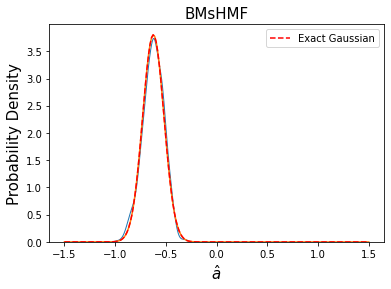

In [30]:
a_poster=pm.sample_posterior_predictive(samples=1000,model=diffusion_model1, 
                                           trace=thinned_trace1 , 
                                           var_names=['xa'])['xa'] 
a_post=-a0/0.83*np.exp(a_poster)                                          
sns.distplot(a_poster, hist = False, kde = True, kde_kws = {'linewidth': 1})
plt.xlabel('$\hat{a}$',fontsize=15)
plt.ylabel('Probability Density',fontsize=15)
plt.title(param,fontsize=15)
plt.savefig(output_dir+spheroid+prior+param+'new_post_a.png', dpi = 300,bbox_inches='tight')
#plt.figure()
sigg=np.std(a_poster)
#x=np.linspace(np.min(D_post),np.max(D_post),1000)
#x=np.copy(np.sort(a_poster))
x=np.copy(np.linspace(-1.5,1.5,200))
y=1/np.sqrt(2*np.pi*sigg**2)*np.exp(-(x-np.mean(a_poster))**2/(2*sigg**2))
plt.plot(x,y)
plt.plot(x,y,'r--',label='Exact Gaussian')
plt.legend()

Here, we compare the experimental data with the predictions of the Bayesian method

/usr/local/lib/python3.7/dist-packages/pymc3/sampling.py:1690: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


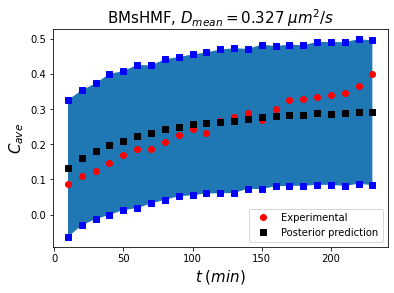

In [18]:
ppsamples1 = pm.sample_posterior_predictive(samples=5000,model=diffusion_model1, 
                                           trace=thinned_trace1 , 
                                           var_names=['y'])['y'] 
np.savetxt(output_dir+spheroid+prior+'new_'+param+'_y_posterior2.csv', np.array(ppsamples1,dtype='f') , delimiter=',')
m_of_c=ppsamples1.mean(0)
#plt.figure(figsize=(10, 8))
ts=np.array(range(1,len(data)+1))*10
pp_lower, pp_upper = np.percentile(ppsamples1, axis=0, q=[2.5, 97.5])
plt.plot(ts,data,'ro',label='Experimental')
plt.plot(ts,m_of_c,'ks',label='Posterior prediction')
plt.xlabel('$t \;  (min)$',fontsize=15)
plt.ylabel('$C_{ave}$',fontsize=15)
plt.fill_between(ts,pp_lower, pp_upper)
plt.plot(ts,pp_lower,'bs')
plt.plot(ts,pp_upper,'bs')
plt.title(param+', $D_{mean}$'+'$={:.3f} \;  \mu m^2/s$'.format(m_of_D1*0.83**2),fontsize=15)
plt.legend(fontsize=10,loc='lower right') 
plt.savefig(output_dir+spheroid+prior+'new_c_'+param+'_{}_consnoise.png'.format(spheroid), dpi = 300,bbox_inches='tight')